# Deep Convolutional Generative Adversarial Network

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/generative/dcgan">
    <img src="https://www.tensorflow.org/images/tf_logo_32px.png" />
    View original notebook on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/radinshayanfar/gan-tf-flowers/blob/master/dcgan.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />
    Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/radinshayanfar/gan-tf-flowers/blob/master/dcgan.ipynb">
    <img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />
    View source on GitHub</a>
  </td>
</table>

This notebook demonstrates how to generate images of flowers using a [Deep Convolutional Generative Adversarial Network](https://arxiv.org/pdf/1511.06434.pdf) (DCGAN). The code is written using the [Keras Sequential API](https://www.tensorflow.org/guide/keras) with a `tf.GradientTape` training loop.

### Setup

In [1]:
# To generate GIFs
%%capture
!pip install imageio
!pip install git+https://github.com/tensorflow/docs

In [1]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import pathlib
import PIL
import tensorflow as tf
from tensorflow.keras import layers
import tensorflow_datasets as tfds
import time

from IPython import display

In [3]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

### Load and prepare the dataset

We use the Flowers dataset to train the generator and the discriminator. The generator will output flower images resembling the dataset flowers.

In [2]:
BATCH_SIZE = 128

In [3]:
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
archive = tf.keras.utils.get_file(origin=dataset_url, extract=True)
data_dir = pathlib.Path(archive).with_suffix('')

In [4]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  label_mode=None,
  seed=123,
  image_size=(64, 64),
  batch_size=BATCH_SIZE
)

Found 3670 files belonging to 1 classes.


 Finally, we scale data to the `TanH` range ($[-1, 1]$).

In [5]:
# aug_layer = tf.keras.layers.RandomFlip(mode='horizontal')
# train_ds = train_ds.map(lambda x: aug_layer(x))
scaler = layers.Rescaling(1./127.5, offset=-1)
train_ds = train_ds.map(lambda x: scaler(x))

## Create the models

Both the generator and discriminator are defined using the [Keras Sequential API](https://www.tensorflow.org/guide/keras#sequential_model).

### The Generator

The generator uses `tf.keras.layers.Conv2DTranspose` (upsampling) layers to produce an image from a seed (random noise). Start with a `Dense` layer that takes this seed as input, then upsample several times until you reach the desired image size of 64x64x3.

In [6]:
filter_size = 5
num_filters = 64
noise_dim = 100

def make_generator_model():
    model = tf.keras.Sequential()

    model.add(layers.Dense(4*4*512, input_shape=(noise_dim,)))
    model.add(layers.Reshape((4, 4, 512)))

    model.add(layers.Conv2DTranspose(num_filters*4, filter_size))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())

    model.add(layers.Conv2DTranspose(num_filters*2, filter_size, strides=2, padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())

    model.add(layers.Conv2DTranspose(num_filters, filter_size, strides=2, padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())

    model.add(layers.Conv2DTranspose(3, filter_size, strides=2, padding='same', activation='tanh'))

    return model

Use the (as yet untrained) generator to create an image.

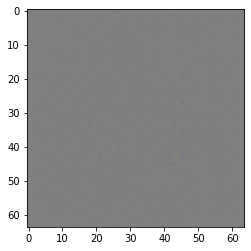

In [7]:
generator = make_generator_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow((generated_image[0, :, :, :] + 1) / 2)  # converting to 0 to 1 scale

### The Discriminator

The discriminator is a CNN-based image classifier.

We augment data using `RandomFlip` class.

In [8]:
dropout_prob = 0.5
num_filters = 64
filter_size = 5
leaky_slope = 0.2

def make_discriminator_model():
    model = tf.keras.Sequential()

    # Preprocessing layers
    # model.add(layers.Resizing(64, 64))
    # model.add(layers.Rescaling(1./127.5, offset=-1))
    model.add(tf.keras.layers.RandomFlip(mode='horizontal'))

    model.add(layers.Dropout(dropout_prob, input_shape=(64, 64, 3)))

    model.add(layers.Conv2D(num_filters, filter_size, strides=2, padding='same'))
    model.add(layers.LeakyReLU(leaky_slope))
    
    model.add(layers.Conv2D(num_filters, filter_size*2, strides=2, padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(leaky_slope))

    model.add(layers.Conv2D(num_filters, filter_size*4, strides=2, padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(leaky_slope))

    model.add(layers.Conv2D(num_filters, filter_size*8, strides=2, padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(leaky_slope))

    model.add(layers.Conv2D(1, 4, strides=2, padding='same'))

    model.add(layers.Flatten())
    model.add(layers.Dense(1, activation='sigmoid'))

    return model

Use the (as yet untrained) discriminator to classify the generated images as real or fake. The model will be trained to output positive values for real images, and negative values for fake images.

In [9]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[0.5000128]], shape=(1, 1), dtype=float32)


## Define the loss and optimizers

Define loss functions and optimizers for both models.


In [10]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=False)

### Discriminator loss

This method quantifies how well the discriminator is able to distinguish real images from fakes. It compares the discriminator's predictions on real images to an array of 1s, and the discriminator's predictions on fake (generated) images to an array of 0s.

If the discriminator learns to discriminate between real and generated images too quickly, then the generator can fail to train. To better balance the learning of the discriminator and the generator, add noise to the real data by randomly flipping the labels assigned to the real images. Here we specify to flip the real labels with probability 0.35. Note that this does not impair the generator as all the generated images are still labeled correctly.

In [11]:
flip_prob = 0.35

def discriminator_loss(real_output, fake_output):
    flipped_label = tf.where(tf.random.uniform(real_output.shape) > flip_prob, 1, 0)
    real_loss = cross_entropy(flipped_label, real_output)
    # real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

### Generator loss
The generator's loss quantifies how well it was able to trick the discriminator. Intuitively, if the generator is performing well, the discriminator will classify the fake images as real (or 1). Here, compare the discriminators decisions on the generated images to an array of 1s.

In [12]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

The discriminator and the generator optimizers are different since we will train two networks separately.

In [13]:
learning_rate = 0.0002
beta_1 = 0.5
beta_2 = 0.999

generator_optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1, beta_2)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1, beta_2)

### Save checkpoints
This notebook also demonstrates how to save and restore models, which can be helpful in case a long running training task is interrupted.

In [14]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

## Define the training loop


In [15]:
EPOCHS = 500
num_examples_to_generate = 16

# You will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

We use a writer to log generator and discrimnator scores. Later, we monitor the score plots using TensorBoard.

In [ ]:
now = time.localtime()
subdir = time.strftime("%d-%b-%Y_%H.%M.%S", now)

summary_dir1 = os.path.join("logs", subdir, "scores")
summary_writer1 = tf.summary.create_file_writer(summary_dir1)

# gen_score = 0
# disc_score = 0
iteration = 0

The training loop begins with generator receiving a random seed as input. That seed is used to produce an image. The discriminator is then used to classify real images (drawn from the training set) and fakes images (produced by the generator). The loss is calculated for each of these models, and the gradients are used to update the generator and discriminator.

In [16]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
# @tf.function
def train_step(images):
    # global gen_score, disc_score
    global iteration
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gen_score = tf.get_static_value(tf.reduce_mean(fake_output))
    disc_score = tf.get_static_value((1 - tf.reduce_mean(fake_output) + tf.reduce_mean(real_output)) / 2)
    with summary_writer1.as_default():
      tf.summary.scalar(name="score/gen", data=gen_score, step=iteration)
      tf.summary.scalar(name="score/disc", data=disc_score, step=iteration)
    
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [17]:
def train(dataset, epochs):
  for epoch in range(epochs):
    global iteration
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)
      summary_writer1.flush()
      iteration += 1

    # Produce images for the GIF as you go
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)

**Generate and save images**


In [18]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(8, 8))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :] * 0.5 + 0.5)
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

## Train the model
Call the `train()` method defined above to train the generator and discriminator simultaneously. Note, training GANs can be tricky. It's important that the generator and discriminator do not overpower each other (e.g., that they train at a similar rate).

At the beginning of the training, the generated images look like random noise. As training progresses, the generated digits will look increasingly real. 

Before training the model, we make sure that TensorBoard is running.

In [ ]:
%tensorboard --logdir logs

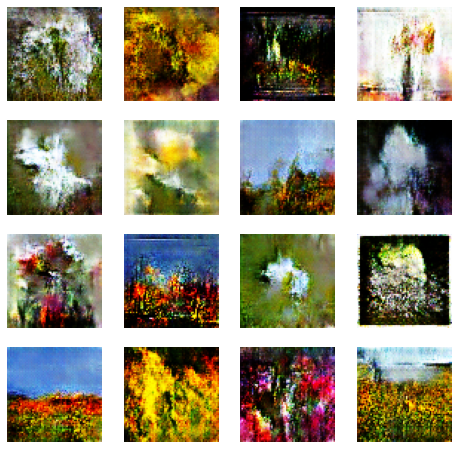

In [19]:
train(train_ds, EPOCHS)

Restore the latest checkpoint.

In [ ]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

## Save trained model

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
%cd drive/MyDrive/dapa/gan

In [20]:
generator.save_weights('gen.h5')
discriminator.save_weights('disc.h5')

## Create a GIF


In [24]:
# Display a single image using the epoch number
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

In [ ]:
%cd /content/

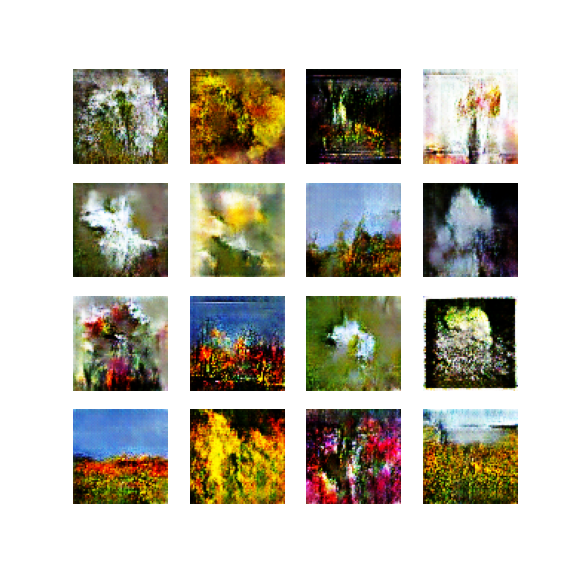

In [25]:
display_image(EPOCHS)

Use `imageio` to create an animated gif using the images saved during training.

In [26]:
anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

In [ ]:
import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file)